## Homework 6, Problem 4 on Kalman filter

ECE C143A/C243A, Spring Quarter 2022, Prof. J.C. Kao, TAs T. Monsoor and W. Yu

Total: 35 points

In this question, we'll implement a Kalman filter for decoding neural activity.
This will specifically be a velocity Kalman filter.
We will be working with the same dataset that we used in prior questions.
To begin, we'll first learn the dynamical system.
Use the first $400$ trials as training data and the remaining $106$ trials as testing data.

In [98]:
# Importing the necessary packages and the data
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import nsp as nsp
import pdb
# Load matplotlib images inline
%matplotlib inline
# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2
data = sio.loadmat('JR_2015-12-04_truncated2.mat') # load the .mat file.
R = data['R'][0,:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### (a) (4 points)  The A-matrix.
We will first learn the parameters of a linear dynamical system.
We'll begin with the $\mathbf{A}$ matrix, which should obey laws of physics.
Our linear dynamical system state at time $k$ is be:
$$\mathbf{x}_k = \left[ \begin{array}{c} p_x(k) \\ p_y(k) \\ v_x(k) \\ v_y(k) \\ 1 \end{array} \right]
$$
where $p_x(k), p_y(k), v_x(k),$ and $v_y(k)$ are the $x$-position, $y$-position, $x$-velocity, and $y$-velocity, respectively, at time $k$.
We'll worry about only deriving an update law for the velocities.

Write what the $\mathbf{A}$ matrix looks like below if if $v_{xx} = 0.7$, $v_{yy} = 0.7$, $v_{yx} = 0$, and $v_{xy} = 0$ and we are using a bin width of $25$ ms.
Recall that the units of position are mm and assume that the velocities you are calculating are in m/s or equivalently mm/ms.


Answer:
$$A=\left[\begin{array}{cc} 1 & 0 & 25 & 0 & 0\\
                        0 & 1 & 0 & 25 &0\\
                        0 & 0 & 0.7 & 0 &0\\
                        0 & 0 & 0& 0.7& 0\\
                        0 & 0 & 0 & 0 & 1 \end{array}\right]$$


### (b) (4 points) Fit the A-matrix.
Calculate the hand velocities in $25$ ms intervals by using a first order Euler approximation, i.e.,

$$v(t) = \frac{cursorPos[t+25] -cursorPos[t]}{25}$$

Find and report the values in the $\mathbf{A}$ matrix.
To be clear, you should only be finding a matrix
$$
\mathbf{A}_s = \left[ \begin{array}{cc} v_{xx} & v_{xy} \\ v_{yx} & v_{yy} \end{array} \right]
$$
and imputing those values into an $\mathbf{A}$ matrix that obeys physics.

In [147]:
#====================================================#
# YOUR CODE HERE:
#   Fit and report the 5x5 matrix A.
positions=scipy.sparse.hstack(R[0:400]['cursorPos'])
positions= scipy.sparse.csc_matrix(positions)
positions_binned=nsp.bin(positions,25,"first")[:2].astype(float)

v=(positions_binned[:,1:]-positions_binned[:,:-1])/25

As=np.matmul(v[:,1:],scipy.linalg.pinv(v[:,:-1]))
print(As)

A=np.array([[1, 0,25,0,0],[0,1,0,25,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,1]]).astype(float)

A[2:4,2:4]=As
print(np.round(A,4))
#====================================================#
# END YOUR CODE
#====================================================#  

[[ 0.77976907 -0.00741686]
 [ 0.0096132   0.78079831]]
[[ 1.000e+00  0.000e+00  2.500e+01  0.000e+00  0.000e+00]
 [ 0.000e+00  1.000e+00  0.000e+00  2.500e+01  0.000e+00]
 [ 0.000e+00  0.000e+00  7.798e-01 -7.400e-03  0.000e+00]
 [ 0.000e+00  0.000e+00  9.600e-03  7.808e-01  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


Answer:
$$A=\left[\begin{array}{cc} 1 & 0 & 25 & 0 & 0\\
                        0 & 1 & 0 & 25 &0\\
                        0 & 0 & 0.77976907& -0.00741686 &0\\
                        0 & 0 & 0.0096132 &  0.78079831 &0 \\
                        0 & 0 & 0 & 0 & 1 \end{array}\right]$$


### (c) (4 points) Fit the C matrix.

For this question, we will only be using `R[i]['spikeRaster']` for the neural data (i.e., ignore `R[i].['spikeRaster2']`).
Calculate the $\mathbf{C}$ matrix by only finding the coefficients mapping velocity (and the constant 1) to the neural data.
(We do not calculate the coefficients corresponding to the mapping of position to neural data, since we are only decoding velocity.
In a position-velocity Kalman filter that decodes both position and velocity, we would fit these coefficients.)
Concretely, find a matrix $\mathbf{C}_s$, which is $96 \times 3$ and is the least-squares optimal mapping from:
$$
\mathbf{y}_k = \mathbf{C}_s \left[ \begin{array}{c} v^x_k \\ v^y_k \\ 1 \end{array} \right]
$$
Then, impute the values of $\mathbf{C_s}$ into the matrix $\mathbf{C}$, which initialized to be a matrix of zeros of size $96 \times 5$.  
Thus, the first two columns of $\mathbf{C}$ should be all zeros, but the last three columns of $\mathbf{C}$ will be populated with the values in $\mathbf{C}_s$.
Bin the neural data in non-overlapping $25$ ms bins.
Find the $\mathbf{C}$ matrix and report the value of `np.sum(C,0)`.


In [148]:
## Part c
#====================================================#
# YOUR CODE HERE:
#   Fit the C matrix, and report np.sum(C, 0)
#====================================================#
positions=scipy.sparse.hstack(R[0:400]['cursorPos'])
positions= scipy.sparse.csc_matrix(positions)
positions_binned=nsp.bin(positions,25,"first")[:2].astype(float)

v=(positions_binned[:,1:]-positions_binned[:,:-1])/25

X=np.vstack((v,np.ones(v.shape[1])))
#print(X.shape)


spikes=scipy.sparse.hstack(R[0:400]['spikeRaster'])
spikes= scipy.sparse.csc_matrix(spikes)
spikes_binned=nsp.bin(spikes,25,"sum").astype(float)

#print(spikes_binned.shape)
Cs=np.matmul(spikes_binned,scipy.linalg.pinv(X))
#print(Cs.shape)
C=np.hstack((np.zeros((Cs.shape[0],2)),Cs))
print(np.sum(C,0))
#====================================================#
# END YOUR CODE
#====================================================#  

[ 0.          0.         -4.49938145  1.70531105 40.19265294]


Answer:`[ 0., 0., -4.49938145, 1.70531105, 40.19265294]`


### (d) (4 points) Fit the W matrix.

Find the $\mathbf{W}$ using the $\mathbf{A}$ matrix calculated in part (b).
We will only want to calculate an uncertainty over the velocity, and not on the positions.
Thus, you will perform the covariance calculation over the velocities, resulting in a $2 \times 2$ matrix $\mathbf{W}_s$.  
You will insert these values into the correct location in the $\mathbf{W}$ matrix, which is everywhere else $0$.
Report the $\mathbf{W}$ matrix.

In [149]:
## Part d
#====================================================#
# YOUR CODE HERE:
#   Fit and report the W matrix.
#====================================================#
Ws=(np.matmul(v[:,1:]-np.matmul(As,v[:,:-1]),(v[:,1:]-np.matmul(As,v[:,:-1])).T))/(v.shape[1]-1)
print(Ws)

W=np.zeros((5,5))
W[2:4,2:4]=Ws
print(W)
#====================================================#
# END YOUR CODE
#====================================================#  

[[ 0.01151216 -0.00079399]
 [-0.00079399  0.01212474]]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.01151216 -0.00079399  0.        ]
 [ 0.          0.         -0.00079399  0.01212474  0.        ]
 [ 0.          0.          0.          0.          0.        ]]


Answer:```[[ 0.01151216, -0.00079399],
       [-0.00079399,  0.01212474]]```


### (e) (4 points) Fit the Q matrix.
Find the $\mathbf{Q}$ matrix using the $\mathbf{C}$ matrix calculated in part (c).
Submit a plot of Q using `plt.imshow(Q)`.
        


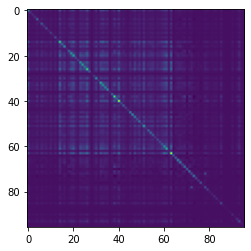

In [154]:
## Part e
#====================================================#
# YOUR CODE HERE:
#   Fit the Q matrix, and visuailze it using plt.imshow(Q)
#====================================================#
positions_binned=nsp.bin(positions,25,"first")[:2].astype(float)

X=np.vstack((positions_binned[:,:-1],v,np.ones(v.shape[1])))


Q=np.matmul(spikes_binned-np.matmul(C,X),(spikes_binned-np.matmul(C,X)).T)/(v.shape[1])
plt.imshow(Q)
plt.show()
#====================================================#
# END YOUR CODE
#====================================================#  

Answer: see above



### (f) (9 points) Write the KF recursion.
Write a function, `KalmanSteadyState.m` that accepts as input the $\mathbf{A, W, C}$, and $\mathbf{Q}$ matrices and returns $\Sigma_\infty$, $\mathbf{K}_\infty$, $\mathbf{M}_1$ and $\mathbf{M}_2$.
We are going to use an assumption made in Gilja*, Nuyujukian* et al., Nature Neuroscience 2012, which is that the monkey sees the cursor whenever it is updated and therefore has no uncertainty in its position.
Thus, in your recursion, make the following modification in the recursion: 
If `S` denotes $\Sigma_{k|1:k-1}$, then immediately after calculating `S`, set:
$$
\mathbf{S[0:2,:] = 0}$$
$$
\mathbf{S[:,0:2] = 0}$$
This removes all uncertainty in the cursor's position.
Use a while loop with the following convergence criterion:`np.max(np.abs(it_d)) > tol`
where `it_d` measures the difference between M1 and M2's entries' between current value and updated value after iteration.
and $\mathbf{tol = 10^{-13}}$.
Submit the values of the $\mathbf{M1}$ matrix and the value of `np.sum(M2,1)`.  

In [151]:
def KalmanSteadyState(A, W, C, Q):

    S_p = np.zeros((5,5)) # previous state estimate cov
    S_c = np.zeros((5,5)) # current state estimate cov
    M1_p = np.zeros((5,5)) # previous M1
    M1_c = np.ones((5,5)) # current M1
    M2_p = np.zeros((5,96)) # previous M2
    M2_c = np.ones((5,96)) # current M2
    tol = math.pow(10, -13)
    count = 0
    
    # Stopping criterion.
    it_d = np.hstack((M1_c.flatten() - M1_p.flatten(),  M2_c.flatten()-M2_p.flatten()))

    while(np.max(np.abs(it_d)) > tol):
        
        #====================================================#
        # YOUR CODE HERE:
        #   Implement the Kalman filter recursion.
        #====================================================#
        M1_p=M1_c
        M2_p=M2_c
        S_p=S_c
        S=np.matmul(np.matmul(A,S_p),A.T)+W

        S[0:2,:]=0
        S[:,0:2]=0

        S_c=S-np.matmul(np.matmul(S,C.T),np.matmul(np.linalg.inv(np.matmul(C,np.matmul(S,C.T))+Q),np.matmul(C,S)))

        M2_c=np.matmul(np.matmul(S,C.T),np.linalg.inv(np.matmul(C,np.matmul(S,C.T))+Q))

        M1_c=A-np.matmul(M2_c,np.matmul(C,A))
        #====================================================#
        # END YOUR CODE
        #====================================================#  
        
        count = count + 1
        it_d = np.hstack((M1_c.flatten() - M1_p.flatten(),  M2_c.flatten()-M2_p.flatten()))
        
    S_st = S_c # steady state covariance
    K_st = M2_c # steady state Kalman gain
    
    return (M1_c,M2_c,S_st,K_st)

After writing this function, run the following code to calculate the steady state parameters.

In [152]:
m1,m2,_,_ = KalmanSteadyState(A, W, C, Q)

print(m1)
print(np.sum(m2,1))

[[ 1.00000000e+00  0.00000000e+00  2.50000000e+01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  2.50000000e+01
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.77629013e-01 -2.53787898e-02
   1.23314734e-02]
 [ 0.00000000e+00  0.00000000e+00 -1.54426706e-02  6.27592684e-01
  -5.85754563e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]]
[ 0.          0.         -0.05834287  0.12670082  0.        ]


Answer:



`M1=[[1,0,25,0,0],
 [0,1,0,25,0],
 [0,0,6.77629013e-01, -2.53787898e-02,1.23314734e-02],
 [ 0, 0, -1.54426706e-02,  6.27592684e-01,-5.85754563e-02],
 [0,0,0,0,1]]`

`np.sum(m2,1)=[0, 0, -0.05834287, 0.12670082, 0]`



### (g) (6 points)  Decode using the KF.
Using the $\mathbf{M}_1$ and $\mathbf{M}_2$ matrix found in part (f), decode the neural activity for each trial in the testing data.
		Initialize $\mathbf{x}_0$ on each trial to be the starting position on the trial, and a velocity of $\mathbf{0}$.
		On one plot, show the true hand positions.
		On a separate plot, show the positions decoded by the Kalman filter.
       


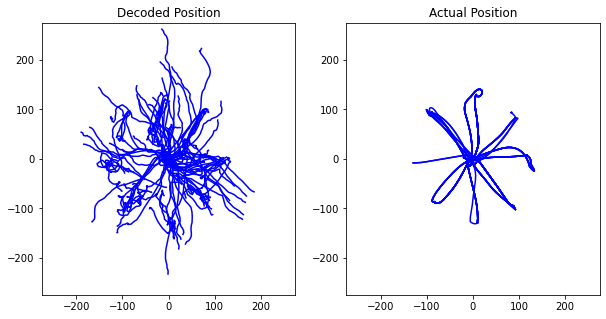

In [153]:
#====================================================#
# YOUR CODE HERE:
#   Decode the activity using a Kalman filter and
#   plot the decoded positions.
#====================================================#
mean_distances=[]

fig,axs=plt.subplots(1,2,figsize=(10,5))
for i in range(400,R.shape[0]):
    Y_test = R[i]['spikeRaster']
    Y_bin_test=nsp.bin(Y_test, 25,'sum').astype('float64')

    Initial_Conditions=R[i]['cursorPos'][0:2,0]

    x_i=np.array([Initial_Conditions[0],Initial_Conditions[1],0,0,1])

    X=np.empty((5,Y_bin_test.shape[1]))
    X[:,0]=x_i
    for i in range(Y_bin_test.shape[1]-1):
        X[:,i+1]=np.matmul(m1,x_i)+np.matmul(m2,Y_bin_test[:,i+1])
        x_i=X[:,i+1]

    axs[0].plot(X[0,:],X[1,:],'b')
    axs[1].plot(R[i]['cursorPos'][0],R[i]['cursorPos'][1],'b')
axs[0].set_ylim([-275,275])
axs[0].set_xlim([-275,275])
axs[0].set_title('Decoded Position')

axs[1].set_ylim([-275,275])
axs[1].set_xlim([-275,275])
axs[1].set_title("Actual Position")
plt.show()
#====================================================#
# END YOUR CODE
#====================================================#  

Answer:  see above

